<a href="https://colab.research.google.com/github/MeowJ/Generative-Adversarial-Network/blob/master/CGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from tempfile import TemporaryFile

%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
[[[-0.04421261 -0.03947144]
  [ 0.02773235 -0.02759501]
  [-0.03908096 -0.03834642]
  [-0.03146221  0.00533062]
  [-0.04697052 -0.03580289]
  [-0.00913483 -0.03625487]
  [-0.02780404 -0.00629573]
  [-0.03573369  0.0030066 ]
  [ 0.00942751 -0.03126867]
  [-0.04833125 -0.01318425]]]


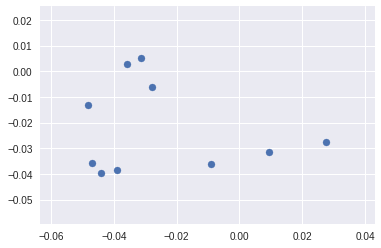

In [0]:
model = Sequential()
model.add(Embedding(10, 2))
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.

# input_array = np.random.randint(10, size=(1, 10))
input_array = np.arange(0, 10).reshape(1, -1)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
# print(output_array.shape)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])

---
#### Getting the data

In [0]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test.shape

11493376/11490434 [==============================] - 2s 0us/step


(10000, 28, 28)

#### Explore visual data

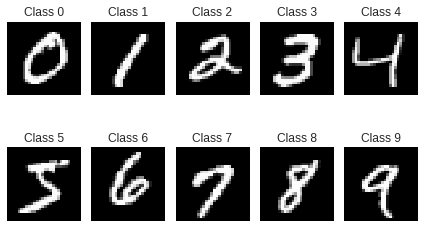

In [0]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

In [0]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
y_train.shape (60000,)
X_train reshape: (60000, 784)


In [0]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Output layer 
generator.add(Dense(img_dim, activation='tanh'))

In [0]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
__________

In [0]:
# Embedding condition in input layer
num_classes = 10

# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)

# latent space
z = Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = Model([z, label], img)

In [0]:
# prints a summary representation of your model
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       1000        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_1

In [0]:
# Discriminator network
discriminator = Sequential()

# Input layer and hidden layer 1
discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

In [0]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total para

In [0]:
# Embedding condition in input layer

# Create label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_dim)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = Input(shape=(img_dim,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity)

In [0]:
# prints a summary representation of your model
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 784)       7840        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           embedding_3[0][0]                
__________________________________________________________________________________________________
multiply_2

In [0]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [0]:
discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

d_g = Model([z, label], validity)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [0]:
# prints a summary representation of your model
d_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 784)          584312      input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            273441      model_1[1][0]                    
          

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch = 1/10, d_loss=0.681, g_loss=0.865                                                                                                     


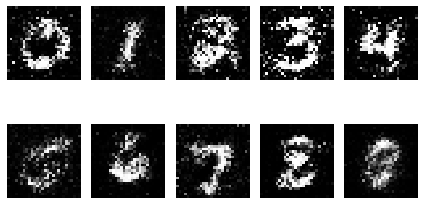

epoch = 2/10, d_loss=0.683, g_loss=0.858                                                                                                     
epoch = 3/10, d_loss=0.661, g_loss=0.839                                                                                                     
epoch = 4/10, d_loss=0.691, g_loss=0.820                                                                                                     
epoch = 5/10, d_loss=0.697, g_loss=0.806                                                                                                     
epoch = 6/10, d_loss=0.653, g_loss=0.800                                                                                                     
epoch = 7/10, d_loss=0.688, g_loss=0.804                                                                                                     
epoch = 8/10, d_loss=0.679, g_loss=0.801                                                                                                     
epoch 

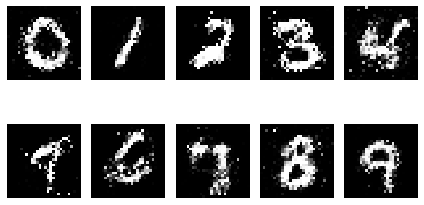

In [0]:
epochs = 10
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

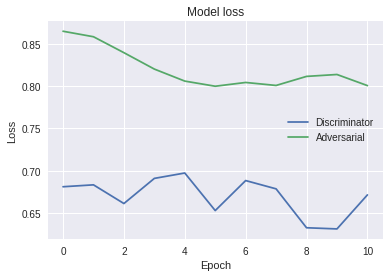

In [0]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

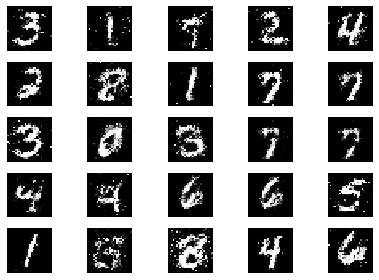

In [0]:
samples = 25
z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
labels = np.random.randint(low=0, high=9, size=samples)
labels = labels.reshape(-1, 1)
        
x_fake = generator.predict([z, labels])
x_fake = x_fake.reshape(samples,28, 28)

for k in range(samples):
  plt.subplot(5, 5, k+1)
  plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
  x_fake[k]=x_fake[k].reshape(28, 28)
  plt.xticks([])
  plt.yticks([])
  
plt.tight_layout()
plt.show()


In [0]:
X_test = x_fake
y_test = labels
print("Image Shape: {}".format(X_test.shape))

Image Shape: (25, 28, 28)


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1357902425098964922, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4222238151435792053
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3811415978329594720
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11276946637
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3276642630100420370
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test_minst, y_test_minst = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.

Image Shape: (28, 28, 1)

Training Set

In [0]:
print("Image Shape: {}".format(X_test.shape))
print("Image Shape: {}".format(y_test.shape))

Image Shape: (25, 28, 28)
Image Shape: (25, 1)


Use images generaged by CGAN to do testing

In [0]:
samples = 10000
z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
labels1 = np.random.randint(low=0, high=10, size=samples)
labels = labels1.reshape(-1, 1)
        
x_fake = generator.predict([z, labels])
x_fake = x_fake.reshape(samples,28, 28,1)


In [0]:
X_test = x_fake
y_test = np.transpose(labels1)
print("Image Shape: {}".format(X_test.shape))
print("Image Shape: {}".format(y_test.shape))

Image Shape: (10000, 28, 28, 1)
Image Shape: (10000,)


In [0]:
import numpy as np

# Pad images with 0s
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test_minst = np.pad(X_test_minst, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train.shape))
print("Updated Image Shape: {}".format(X_test.shape))

Updated Image Shape: (55000, 32, 32, 1)
Updated Image Shape: (10000, 32, 32, 1)


Label of the image is:3


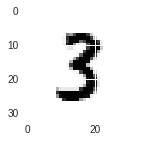

In [0]:
import pdb
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image)
print("Label of the image is:%d"%y_train[index])

In [0]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [0]:
import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 128

In [0]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
 
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6], mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b 
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits 

In [0]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

In [0]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)  
loss_operation = tf.reduce_mean(cross_entropy)
#optimizer = tf.train.AdamOptimizer(learning_rate=rate)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

In [0]:
predictions_operation = tf.argmax(tf.nn.softmax(logits), 1)
correct_prediction = tf.equal(predictions_operation, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    all_predictions = []
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, predictions = sess.run([accuracy_operation, predictions_operation], feed_dict={x: batch_x, y: batch_y})
        
        all_predictions = np.hstack((all_predictions, predictions))
        total_accuracy += (accuracy * len(batch_x))
    all_predictions = np.array(all_predictions)
    return total_accuracy / num_examples, all_predictions
  
def predict(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    all_predictions = []
    #for offset in range(0, num_examples, BATCH_SIZE):
    batch_x, batch_y = X_data, y_data
    accuracy, predictions = sess.run([accuracy_operation, predictions_operation], feed_dict={x: batch_x, y: batch_y})
        
    #all_predictions = np.hstack((all_predictions, predictions))
    all_predictions=predictions
    total_accuracy =accuracy
    all_predictions = np.array(all_predictions)
    return total_accuracy / num_examples, all_predictions

In [0]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
         
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy, validation_predictions = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.106

EPOCH 2 ...
Validation Accuracy = 0.182

EPOCH 3 ...
Validation Accuracy = 0.459

EPOCH 4 ...
Validation Accuracy = 0.614

EPOCH 5 ...
Validation Accuracy = 0.685

EPOCH 6 ...
Validation Accuracy = 0.768

EPOCH 7 ...
Validation Accuracy = 0.821

EPOCH 8 ...
Validation Accuracy = 0.850

EPOCH 9 ...
Validation Accuracy = 0.871

EPOCH 10 ...
Validation Accuracy = 0.883

EPOCH 11 ...
Validation Accuracy = 0.889

EPOCH 12 ...
Validation Accuracy = 0.894

EPOCH 13 ...
Validation Accuracy = 0.903

EPOCH 14 ...
Validation Accuracy = 0.909

EPOCH 15 ...
Validation Accuracy = 0.911

EPOCH 16 ...
Validation Accuracy = 0.917

EPOCH 17 ...
Validation Accuracy = 0.919

EPOCH 18 ...
Validation Accuracy = 0.919

EPOCH 19 ...
Validation Accuracy = 0.921

EPOCH 20 ...
Validation Accuracy = 0.927

EPOCH 21 ...
Validation Accuracy = 0.928

EPOCH 22 ...
Validation Accuracy = 0.929

EPOCH 23 ...
Validation Accuracy = 0.933

EPOCH 24 ...
Validation Accura

Test pre-trained CNN

In [0]:
with tf.Session() as session:
    print("Updated Image Shape: {}".format(X_test[0].shape))
    saver.restore(session, tf.train.latest_checkpoint('.'))
    
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))

    test_accuracy, test_predictions = evaluate(X_test, y_test)
    print("Fake Test Accuracy = {:.3f}".format(test_accuracy))
    
    test_accuracy_minst, test_predictions_minst= evaluate(X_test_minst, y_test_minst)
    print("Real Test Accuracy = {:.3f}".format(test_accuracy_minst))
    
    test_data  = X_test
    #test_data=X_test


    #  pdb.set_trace()
    # COMPUTE ACCURACY FOR TEST DATA
    batch_size = 100
    test_size   = test_data.shape[0]
    total_batch = int(test_size / batch_size)
    acc_buffer  = []
    preds = []
    for i in range(total_batch):
        offset = (i * batch_size) % (test_size)
        batch_xs = test_data[offset:(offset + batch_size), :]        
          #y_final=session.run(y, feed_dict={x: batch_xs, is_training: False})
        #saver.restore(session, tf.train.latest_checkpoint('.'))
        pred_softmax = predict(batch_xs,y_test[offset:(offset + batch_size)])          
        #y_final = session.run(y, feed_dict={x: batch_xs})
        #y_final = sess.run([predictions_operation], feed_dict={x: batch_x})
        #pred_softmax = softmax(y_final)
        preds.append(pred_softmax)


    #preds = np.concatenate(preds, 0)
    preds = test_predictions.reshape(-1,1)
    preds = np.concatenate(preds, 0)
    scores = []
    splits = 10
    for i in range(splits):
      part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits)]
      #part = part+1
      kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
      kl = np.mean(np.sum(kl))
      scores.append(np.exp(kl))

    #scores=(scores-np.random.randint(1,high=2,size=10))*10000000
    #icp.append((np.mean(scores) , np.std(scores)))
    #print("Inception score is: %f, %f" % (np.mean(scores) , np.std(scores)))
    

Updated Image Shape: (32, 32, 1)
INFO:tensorflow:Restoring parameters from ./lenet
Validation Accuracy = 0.945
Fake Test Accuracy = 0.618
Real Test Accuracy = 0.944


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


In [0]:
scores

[5.825613079542755e+294,
 inf,
 3.1044539289712118e+293,
 7.42992689095901e+291,
 3.475615633823791e+297,
 2.353277224859084e+283,
 3.3376540858724826e+297,
 1.8736803925392812e+284,
 7.711470383085958e+290,
 2.672928320595354e+277]

Confusiton matrix

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

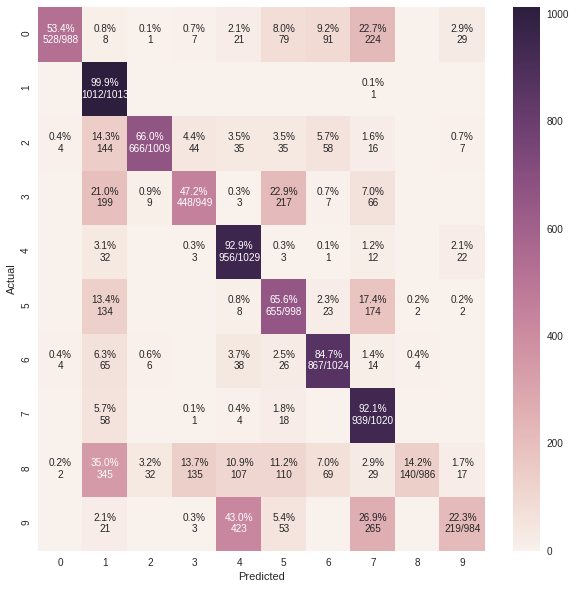

In [0]:
label=[0,1,2,3,4,5,6,7,8,9]
cm_analysis(y_test, test_predictions, label, ymap=None, figsize=(10,10))

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    img_shape = (32, 32)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

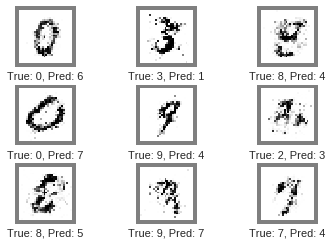

In [0]:
def plot_example_errors(y_pred, y_true):
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct_prediction = np.equal(y_pred, y_true)
       
    # Negate the boolean array.
    incorrect = np.equal(correct_prediction, False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = y_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_true[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9].astype(np.int))

plot_example_errors(test_predictions, y_test)